In [7]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from scipy.signal import welch
import pywt
import torch.nn.functional as F

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
LATENT_DIM = 7
HIDDEN_DIM = 128
SEQ_LENGTH = 1139
INPUT_DIM = 1
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
ALPHA = 1e-6
PATIENCE = 3
DATA_FOLDER = '5min_smoothed_data/'
OUTCOME_FILE = 'valid_patients_outcome.csv'


# Utility Functions
class EEGUtil:
    @staticmethod
    def load_data(file_path, column_name='BCI'):
        data = pd.read_csv(file_path)
        return data[column_name].values

    @staticmethod
    def padding(signal, target_length):
        if len(signal) < target_length:
            return np.pad(signal, (0, target_length - len(signal)), 'constant', constant_values=-1)
        return signal[:target_length]


# Dataset Class
class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, target_length=600, use_labels=False):
        self.data_folder = data_folder
        self.target_length = target_length
        self.use_labels = use_labels
        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

        if use_labels and outcome_file:
            self.outcome_dict = pd.read_csv(outcome_file).set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        else:
            self.outcome_dict = {}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        patient_id = filename.split('.')[0]
        file_path = os.path.join(self.data_folder, filename)
        signal = EEGUtil.load_data(file_path)

        processed_signal = EEGUtil.padding(signal, self.target_length)
        label = self.get_label(patient_id) if self.use_labels else -1
        return torch.tensor(processed_signal, dtype=torch.float32).unsqueeze(-1), label  # Add feature dim

    def get_label(self, patient_id):
        return 1 if self.outcome_dict.get(patient_id) == 'Good Outcome' else 0


# RNN-VAE Model
class RNNVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_length, rnn_type='lstm'):
        super(RNNVAE, self).__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.seq_length = seq_length
        self.rnn_type = rnn_type.lower()
        
        # RNN Encoder
        if self.rnn_type == 'lstm':
            self.encoder_rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        elif self.rnn_type == 'gru':
            self.encoder_rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError("Unsupported RNN type. Choose from 'lstm' or 'gru'.")
        
        # Fully connected layers for mean and logvar
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Fully connected layer to expand latent space to RNN hidden state
        self.fc_latent_to_hidden = nn.Linear(latent_dim, hidden_dim)
        
        # RNN Decoder
        if self.rnn_type == 'lstm':
            self.decoder_rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        elif self.rnn_type == 'gru':
            self.decoder_rnn = nn.GRU(input_dim, hidden_dim, batch_first=True)
        
        # Fully connected layer to reconstruct output
        self.fc_output = nn.Linear(hidden_dim, input_dim)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        # Encode
        _, hidden = self.encoder_rnn(x)
        if self.rnn_type == 'lstm':
            hidden = hidden[0]  # Get the hidden state from LSTM (ignore cell state)
        hidden = hidden[-1]  # Take the last layer's hidden state
        mean = self.fc_mean(hidden)
        logvar = self.fc_logvar(hidden)
        
        # Reparameterization
        z = self.reparameterize(mean, logvar)
        
        # Decode
        hidden_decoder = self.fc_latent_to_hidden(z).unsqueeze(0)
        if self.rnn_type == 'lstm':
            hidden_decoder = (hidden_decoder, torch.zeros_like(hidden_decoder))
        decoded_seq, _ = self.decoder_rnn(x, hidden_decoder)
        reconstruction = self.fc_output(decoded_seq)
        
        return reconstruction, mean, logvar
    
    def get_embedding(self, x):
        """
        从模型中提取潜在空间表示（即均值向量）。
        """
        self.eval()  # 切换到评估模式，确保不更新梯度
        with torch.no_grad():
            _, hidden = self.encoder_rnn(x)
            if self.rnn_type == 'lstm':
                hidden = hidden[0]
            hidden = hidden[-1]
            mean = self.fc_mean(hidden)
        return mean


# Loss Function
def loss_function(reconstruction, x, mean, logvar, alpha=1e-6):
    recon_loss = F.mse_loss(reconstruction, x, reduction='mean')
    kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + alpha * kl_div


# Training Function
def train(model, dataloader, optimizer, criterion, alpha):
    model.train()
    total_loss = 0
    for x, _ in dataloader:
        x = x.to(device)
        optimizer.zero_grad()
        reconstruction, mean, logvar = model(x)
        loss = criterion(reconstruction, x, mean, logvar, alpha)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)


# Testing Function
def test(model, dataloader, criterion, alpha):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            reconstruction, mean, logvar = model(x)
            loss = criterion(reconstruction, x, mean, logvar, alpha)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(dataloader.dataset)




In [2]:
# Main Logic
eeg_dataset = EEGDataset(DATA_FOLDER, OUTCOME_FILE, target_length=SEQ_LENGTH)
train_size = int(0.8 * len(eeg_dataset))
test_size = len(eeg_dataset) - train_size
train_dataset, test_dataset = random_split(eeg_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



Epoch 1/100, Train Loss: 0.7172, Test Loss: 0.2527
Epoch 2/100, Train Loss: 0.1891, Test Loss: 0.1733
Epoch 3/100, Train Loss: 0.1097, Test Loss: 0.0901
Epoch 4/100, Train Loss: 0.0414, Test Loss: 0.0168
Epoch 5/100, Train Loss: 0.0143, Test Loss: 0.0148
Epoch 6/100, Train Loss: 0.0108, Test Loss: 0.0112
Epoch 7/100, Train Loss: 0.0094, Test Loss: 0.0102
Epoch 8/100, Train Loss: 0.0086, Test Loss: 0.0093
Epoch 9/100, Train Loss: 0.0081, Test Loss: 0.0088
Epoch 10/100, Train Loss: 0.0076, Test Loss: 0.0083
Epoch 11/100, Train Loss: 0.0073, Test Loss: 0.0079
Epoch 12/100, Train Loss: 0.0070, Test Loss: 0.0075
Epoch 13/100, Train Loss: 0.0067, Test Loss: 0.0073
Epoch 14/100, Train Loss: 0.0064, Test Loss: 0.0070
Epoch 15/100, Train Loss: 0.0062, Test Loss: 0.0067
Epoch 16/100, Train Loss: 0.0060, Test Loss: 0.0065
Epoch 17/100, Train Loss: 0.0058, Test Loss: 0.0062
Epoch 18/100, Train Loss: 0.0056, Test Loss: 0.0060
Epoch 19/100, Train Loss: 0.0054, Test Loss: 0.0058
Epoch 20/100, Train L

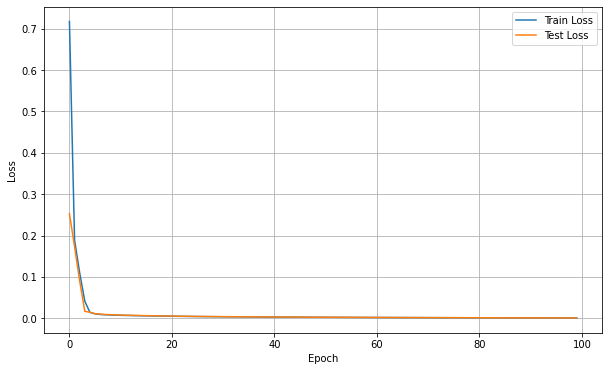

In [3]:
model = RNNVAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM, SEQ_LENGTH, rnn_type='lstm').to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Early stopping variables
best_test_loss = float('inf')
epochs_no_improve = 0

train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    train_loss = train(model, train_loader, optimizer, loss_function, ALPHA)
    test_loss = test(model, test_loader, loss_function, ALPHA)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print("Early stopping...")
        break

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. 提取潜在特征
def extract_latent_features(vae_model, dataset):
    latent_features = []
    labels = []

    for i in range(len(dataset)):
        signal, label = dataset[i]  # 获取信号和标签
        signal = signal.unsqueeze(0).to(device)  # 增加 batch 维度并移动到设备

        # 使用 forward 提取 mean
        with torch.no_grad():
            _, mean, _ = vae_model(signal)  # forward 方法返回 reconstruction, mean, logvar
        latent_features.append(mean.cpu().numpy().flatten())  # 将 mean 转为 NumPy 格式
        labels.append(label)

    return np.array(latent_features), np.array(labels)


# 2. 降维与可视化
def visualize_latent_space(latent_features, labels, method='pca', dimensions=2):
    if dimensions not in [2, 3]:
        raise ValueError("Dimensions must be 2 or 3.")
    if method not in ['pca', 'tsne']:
        raise ValueError("Method should be 'pca' or 'tsne'.")

    # 降维
    if method == 'pca':
        reducer = PCA(n_components=dimensions)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"PCA of Latent Features ({dimensions}D)"
    else:
        reducer = TSNE(n_components=dimensions, random_state=42)
        reduced_features = reducer.fit_transform(latent_features)
        title = f"t-SNE of Latent Features ({dimensions}D)"

    # 可视化
    if dimensions == 2:
        plt.figure(figsize=(10, 8))
        color_map = {0: 'blue', 1: 'red'}
        colors = [color_map[label] for label in labels]
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.legend(handles=[
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Bad Outcome'),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Good Outcome')
        ], title="Labels")
        plt.show()

    elif dimensions == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        color_map = {0: 'blue', 1: 'red'}
        colors = [color_map[label] for label in labels]
        ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.7)

        ax.set_title(title)
        ax.set_xlabel("Component 1")
        ax.set_ylabel("Component 2")
        ax.set_zlabel("Component 3")
        plt.show()


# 3. 数据集划分
def split_dataset(latent_features, labels):
    return train_test_split(latent_features, labels, test_size=0.3, stratify=labels, random_state=42)


# 4. SVM 训练与验证
def train_and_evaluate_svm(X_train, X_test, y_train, y_test):
    svm_model = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42)
    svm_model.fit(X_train, y_train)

    # 预测
    y_pred = svm_model.predict(X_test)

    # 评估
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of SVM on latent features: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


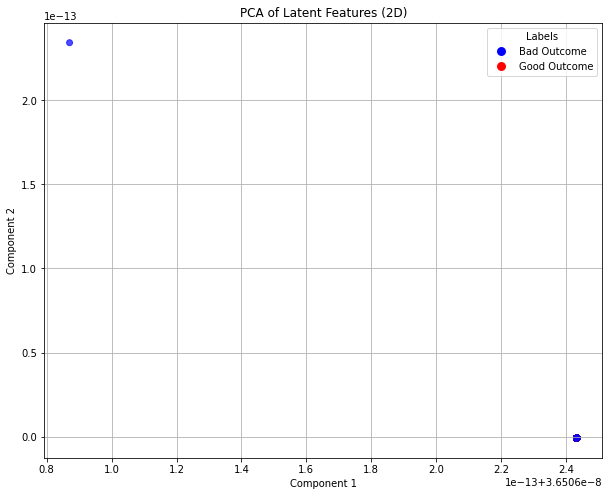

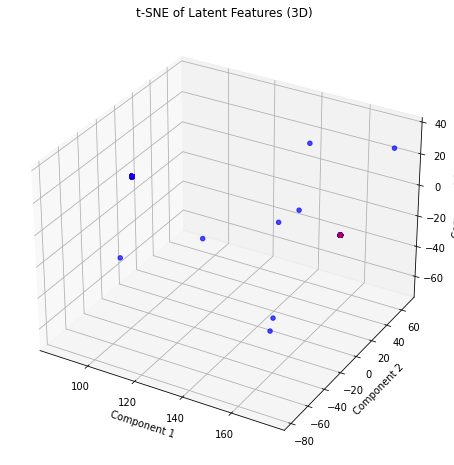

In [10]:
# 假设已定义并训练好的 VAE 模型和 EEG 数据集
eeg_dataset = EEGDataset(DATA_FOLDER, OUTCOME_FILE, target_length=SEQ_LENGTH, use_labels=True)

    # 提取潜在特征
latent_features, labels = extract_latent_features(model, eeg_dataset)

    # 可视化潜在空间
visualize_latent_space(latent_features, labels, method='pca', dimensions=2)
visualize_latent_space(latent_features, labels, method='tsne', dimensions=3)

In [11]:
# 划分数据集
X_train, X_test, y_train, y_test = split_dataset(latent_features, labels)
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

# SVM 训练与评估
train_and_evaluate_svm(X_train, X_test, y_train, y_test)

Training set class distribution: [172  36]
Testing set class distribution: [74 16]
Accuracy of SVM on latent features: 0.1778

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        74
           1       0.18      1.00      0.30        16

    accuracy                           0.18        90
   macro avg       0.09      0.50      0.15        90
weighted avg       0.03      0.18      0.05        90


Confusion Matrix:
[[ 0 74]
 [ 0 16]]


/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
